# Spatially correlated stochastic noise #

To make ocean currents based perturbations, 
it better to adapte randomness which contains spatial correlation information of ocean. </br>
To do this, in this notebook, try to make a **stochastic noise with Gaussian filtering** for spatial correlation. </br>
Furthermore, **information on ocean dynamics** derived from climatological anomalies is being introduced into the noise.

# White_noise with Gaussian filter #

By image processing package, let's make simple Guassian filtered white noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
def white_noise_to_correlated(shape, correlation_length, amplitude=1.0, seed=None):
    """
    Convert white noise to spatially correlated noise using Gaussian filtering.
    
    Parameters:
    -----------
    shape : tuple
        Shape of the output noise field (ny, nx) or (ny, nx, nt) for time series
    correlation_length : float
        Correlation length scale in grid points (controls spatial smoothness)
    amplitude : float
        Standard deviation of the output noise field
    seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    correlated_noise : ndarray
        Spatially correlated noise field
    """
    from scipy.ndimage import gaussian_filter
    
    # Generate white noise with optional seed
    if seed is not None:
        rng = np.random.RandomState(seed)
        white_noise = rng.randn(*shape)
    else:
        white_noise = np.random.randn(*shape)
    
    # Apply Gaussian filter to create spatial correlations
    # sigma = correlation_length / (2 * sqrt(2 * ln(2))) for FWHM definition
    # But commonly we just use correlation_length directly as sigma
    sigma = correlation_length
    
    if len(shape) == 2:
        # 2D spatial field
        correlated_noise = gaussian_filter(white_noise, sigma=sigma)
    elif len(shape) == 3:
        # 3D field (2D space + time), apply spatial filtering only
        correlated_noise = gaussian_filter(white_noise, sigma=[sigma, sigma, 0])
    
    # Normalize to desired amplitude
    correlated_noise = correlated_noise / np.std(correlated_noise) * amplitude
    
    return correlated_noise

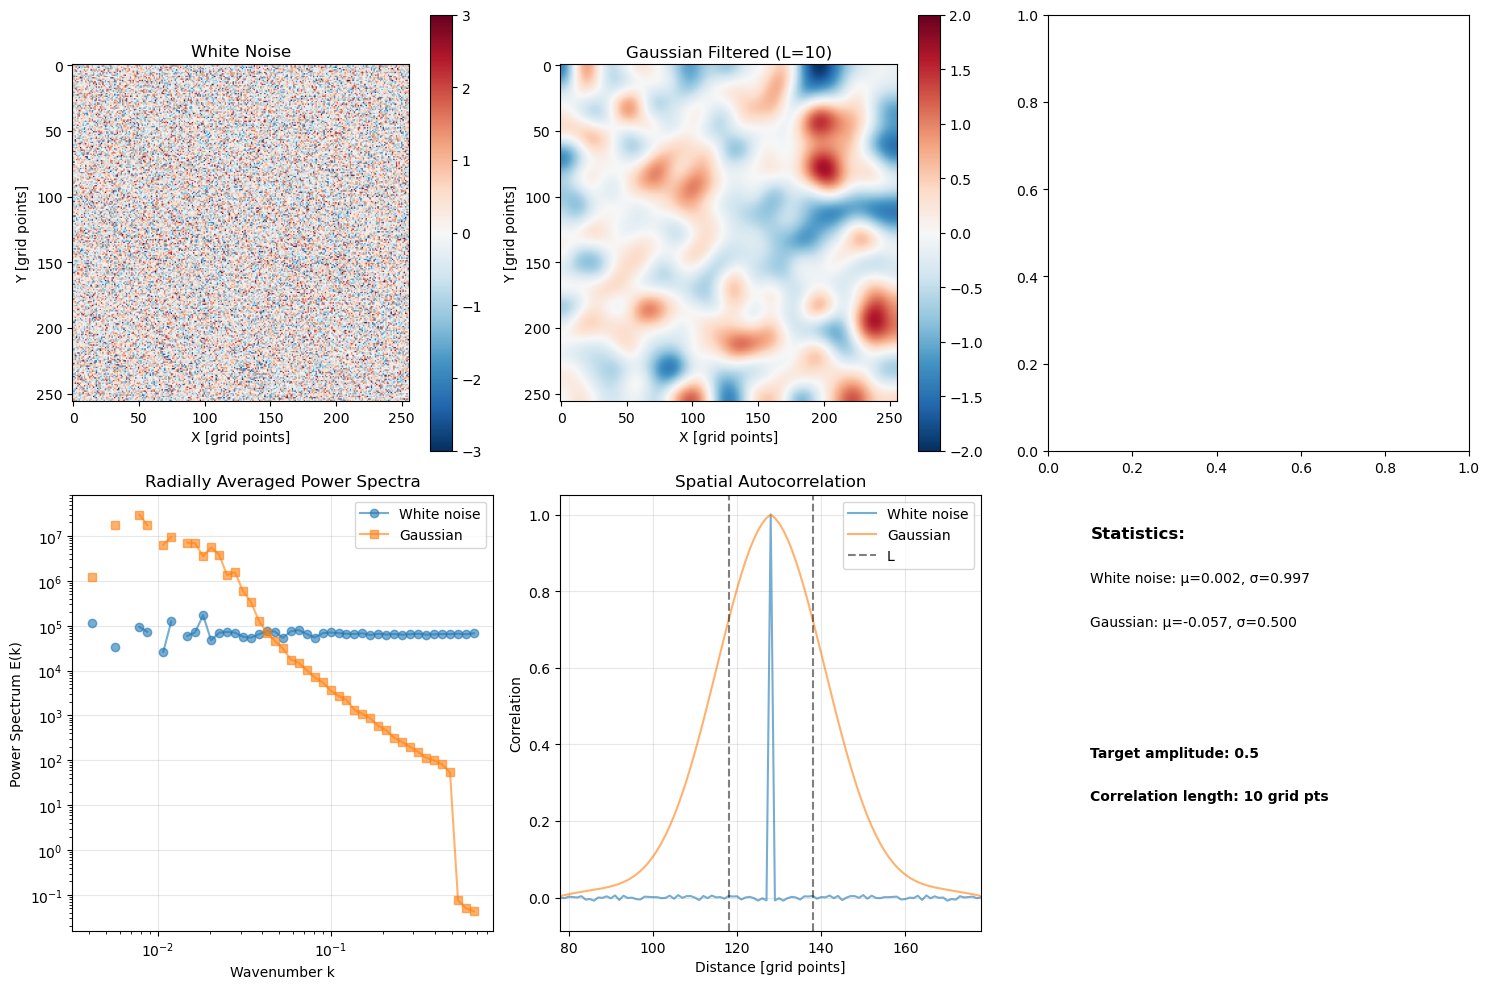

In [26]:

# Example usage and visualization
nx, ny = 256, 256
correlation_length = 10  # grid points
amplitude = 0.5

# Gaussian filtering
noise_gaussian = white_noise_to_correlated((ny, nx), correlation_length, amplitude, seed=12)

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# White noise for comparison
white = np.random.randn(ny, nx)

# Plot noise fields
im0 = axes[0, 0].imshow(white, cmap='RdBu_r', vmin=-3, vmax=3)
axes[0, 0].set_title('White Noise')
axes[0, 0].set_xlabel('X [grid points]')
axes[0, 0].set_ylabel('Y [grid points]')
plt.colorbar(im0, ax=axes[0, 0])

im1 = axes[0, 1].imshow(noise_gaussian, cmap='RdBu_r', vmin=-2, vmax=2)
axes[0, 1].set_title(f'Gaussian Filtered (L={correlation_length})')
axes[0, 1].set_xlabel('X [grid points]')
axes[0, 1].set_ylabel('Y [grid points]')
plt.colorbar(im1, ax=axes[0, 1])

# Compute and plot 2D power spectra
def power_spectrum_2d(field):
    fft = np.fft.fft2(field)
    power = np.abs(fft)**2
    ny, nx = field.shape
    kx = np.fft.fftfreq(nx)
    ky = np.fft.fftfreq(ny)
    KX, KY = np.meshgrid(kx, ky)
    K = np.sqrt(KX**2 + KY**2)
    return K, power

# Radially averaged spectra
def radial_spectrum(field, nbins=50):
    K, power = power_spectrum_2d(field)
    k_flat = K.flatten()
    power_flat = power.flatten()
    
    k_bins = np.logspace(np.log10(k_flat[k_flat>0].min()), 
                         np.log10(k_flat.max()), nbins)
    k_centers = (k_bins[:-1] + k_bins[1:]) / 2
    
    power_binned = []
    for i in range(len(k_bins)-1):
        mask = (k_flat >= k_bins[i]) & (k_flat < k_bins[i+1])
        if mask.sum() > 0:
            power_binned.append(power_flat[mask].mean())
        else:
            power_binned.append(np.nan)
    
    return k_centers, np.array(power_binned)

k1, p1 = radial_spectrum(white)
k2, p2 = radial_spectrum(noise_gaussian)

axes[1, 0].loglog(k1, p1, 'o-', alpha=0.6, label='White noise')
axes[1, 0].loglog(k2, p2, 's-', alpha=0.6, label='Gaussian')
axes[1, 0].set_xlabel('Wavenumber k')
axes[1, 0].set_ylabel('Power Spectrum E(k)')
axes[1, 0].set_title('Radially Averaged Power Spectra')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Compute spatial correlation functions
def spatial_correlation(field):
    from scipy.signal import correlate
    ny, nx = field.shape
    field_normalized = (field - field.mean()) / field.std()
    corr = correlate(field_normalized, field_normalized, mode='same', method='fft')
    corr = corr / corr.max()
    return corr

corr_white = spatial_correlation(white)
corr_gaussian = spatial_correlation(noise_gaussian)

# Plot 1D slices through center
center_y = ny // 2
axes[1, 1].plot(corr_white[center_y, :], alpha=0.6, label='White noise')
axes[1, 1].plot(corr_gaussian[center_y, :], alpha=0.6, label='Gaussian')
axes[1, 1].axvline(nx//2 + correlation_length, color='k', linestyle='--', alpha=0.5, label='L')
axes[1, 1].axvline(nx//2 - correlation_length, color='k', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Distance [grid points]')
axes[1, 1].set_ylabel('Correlation')
axes[1, 1].set_title('Spatial Autocorrelation')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim([nx//2 - 50, nx//2 + 50])

# Statistics comparison
axes[1, 2].text(0.1, 0.9, 'Statistics:', fontsize=12, fontweight='bold', transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.8, f'White noise: μ={white.mean():.3f}, σ={white.std():.3f}', 
                transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.7, f'Gaussian: μ={noise_gaussian.mean():.3f}, σ={noise_gaussian.std():.3f}', 
                transform=axes[1, 2].transAxes)
axes[1, 2].text(0.1, 0.4, f'Target amplitude: {amplitude}', 
                transform=axes[1, 2].transAxes, fontweight='bold')
axes[1, 2].text(0.1, 0.3, f'Correlation length: {correlation_length} grid pts', 
                transform=axes[1, 2].transAxes, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


# Put ocean dynamics in Gaussian filtered noise #

Apply more realistic noise correpond to ocean dynamic.

## Define function ##
1. Make region box for different correlation length.
2. Make correlation length field for global scheme.
    - land masking
3. Apply Gaussin filter from defined correlation field.

In [4]:
def create_correlation_length_field(shape, regions, default):
    """
    Create a field specifying correlation length at each location.
    
    Parameters:
    -----------
    shape : tuple
        Shape of the output field (ny, nx)
    regions : list of dict
        List of region specifications with correlation lengths
    default : background correlation length
    
    Returns:
    --------
    L_field : ndarray
        2D field with spatially-varying correlation length
    """
    ny, nx = shape
    L_field = np.ones((ny, nx)) * default  # Default correlation length
    
    y, x = np.mgrid[0:ny, 0:nx]
    
    for region in regions:
        mask = np.zeros((ny, nx))
        reg_type = region['type']
        correlation_length = region.get('correlation_length', 20.0)
        blend = region.get('blend', True)
        blend_width = region.get('blend_width', 30)
        
        if reg_type == 'box':
            coords = region['coords']
            y_min, y_max = coords['y_range']
            x_min, x_max = coords['x_range']
            
            if blend:
                from scipy.ndimage import distance_transform_edt
                box_mask = ((y >= y_min) & (y < y_max) & 
                           (x >= x_min) & (x < x_max)).astype(float)
                dist_inside = distance_transform_edt(box_mask)
                mask = np.minimum(1.0, dist_inside / blend_width)
            else:
                mask = ((y >= y_min) & (y < y_max) & 
                       (x >= x_min) & (x < x_max)).astype(float)
        
        elif reg_type == 'circle':
            coords = region['coords']
            cy, cx = coords['center']
            radius = coords['radius']
            dist = np.sqrt((y - cy)**2 + (x - cx)**2)
            
            if blend:
                mask = np.clip(1.0 - (dist - radius) / blend_width, 0, 1)
            else:
                mask = (dist <= radius).astype(float)
        
        elif reg_type == 'gradient':
            # Linear gradient from one edge to another
            coords = region['coords']
            direction = coords.get('direction', 'x')  # 'x' or 'y'
            L_start = coords.get('L_start', 10.0)
            L_end = coords.get('L_end', 100.0)
            
            if direction == 'x':
                gradient = np.linspace(L_start, L_end, nx)
                L_field = np.tile(gradient, (ny, 1))
            else:  # 'y'
                gradient = np.linspace(L_start, L_end, ny)
                L_field = np.tile(gradient[:, np.newaxis], (1, nx))
            continue  # Don't blend with mask
        
        # Blend this region's correlation length with existing field
        L_field = L_field * (1 - mask) + correlation_length * mask
    
    return L_field

In [38]:
def spatially_varying_gaussian_filter(shape, correlation_length_field, amplitude=1.0, seed=None):
    """
    Generate correlated noise with spatially-varying correlation length.
    Uses a multi-scale approach: generates noise at different scales and blends them.
    
    Parameters:
    -----------
    shape : tuple
        Shape of the output noise field (ny, nx)
    correlation_length_field : ndarray
        2D field specifying correlation length at each location
    amplitude : float
        Standard deviation of the output noise field
    seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    correlated_noise : ndarray
        Noise field with spatially-varying correlation structure
    """
    from scipy.ndimage import gaussian_filter
    
    ny, nx = shape
    
    # Get the range of correlation lengths (ignoring NaN)
    L_min = np.nanmin(correlation_length_field)
    L_max = np.nanmax(correlation_length_field)
    
    # Create a set of base scales (logarithmically spaced)
    n_scales = 5
    L_scales = np.logspace(np.log10(max(L_min, 1)), np.log10(L_max), n_scales)
    
    # Generate ONE white noise field and filter it at different scales
    # This ensures reproducibility with the seed parameter
    if seed is not None :
        rng = np.random.RandomState(seed)
        white_noise = rng.randn(ny, nx)
    else :
        white_noise = np.random.randn(ny, nx)
    
    noise_scales = []
    for L in L_scales:
        filtered = gaussian_filter(white_noise, sigma=L)
        noise_scales.append(filtered)
    
    # Blend the different scales based on local correlation length
    output = np.zeros((ny, nx))
    
    for i, L in enumerate(L_scales):
        # Weight function: higher weight where correlation_length_field matches this scale
        # Using Gaussian weighting in log-space
        log_L = np.log(L)
        log_L_field = np.log(np.maximum(correlation_length_field, 1e-6))
        
        # Weight peaks at scales matching the local correlation length
        weight = np.exp(-((log_L_field - log_L)**2) / (2 * 0.5**2))
        
        output += weight * noise_scales[i]
    
    # Normalize weights (divide by sum of weights at each location)
    total_weight = np.zeros((ny, nx))
    for i, L in enumerate(L_scales):
        log_L = np.log(L)
        log_L_field = np.log(np.maximum(correlation_length_field, 1e-6))
        weight = np.exp(-((log_L_field - log_L)**2) / (2 * 0.5**2))
        total_weight += weight
    
    output = output / (total_weight + 1e-10)
    
    # Restore NaN where correlation_length_field was NaN
    output = np.where(np.isnan(correlation_length_field), np.nan, output)
    
    # Normalize to desired amplitude (only using valid values)
    output = output / np.nanstd(output) * amplitude / 10
    
    return output


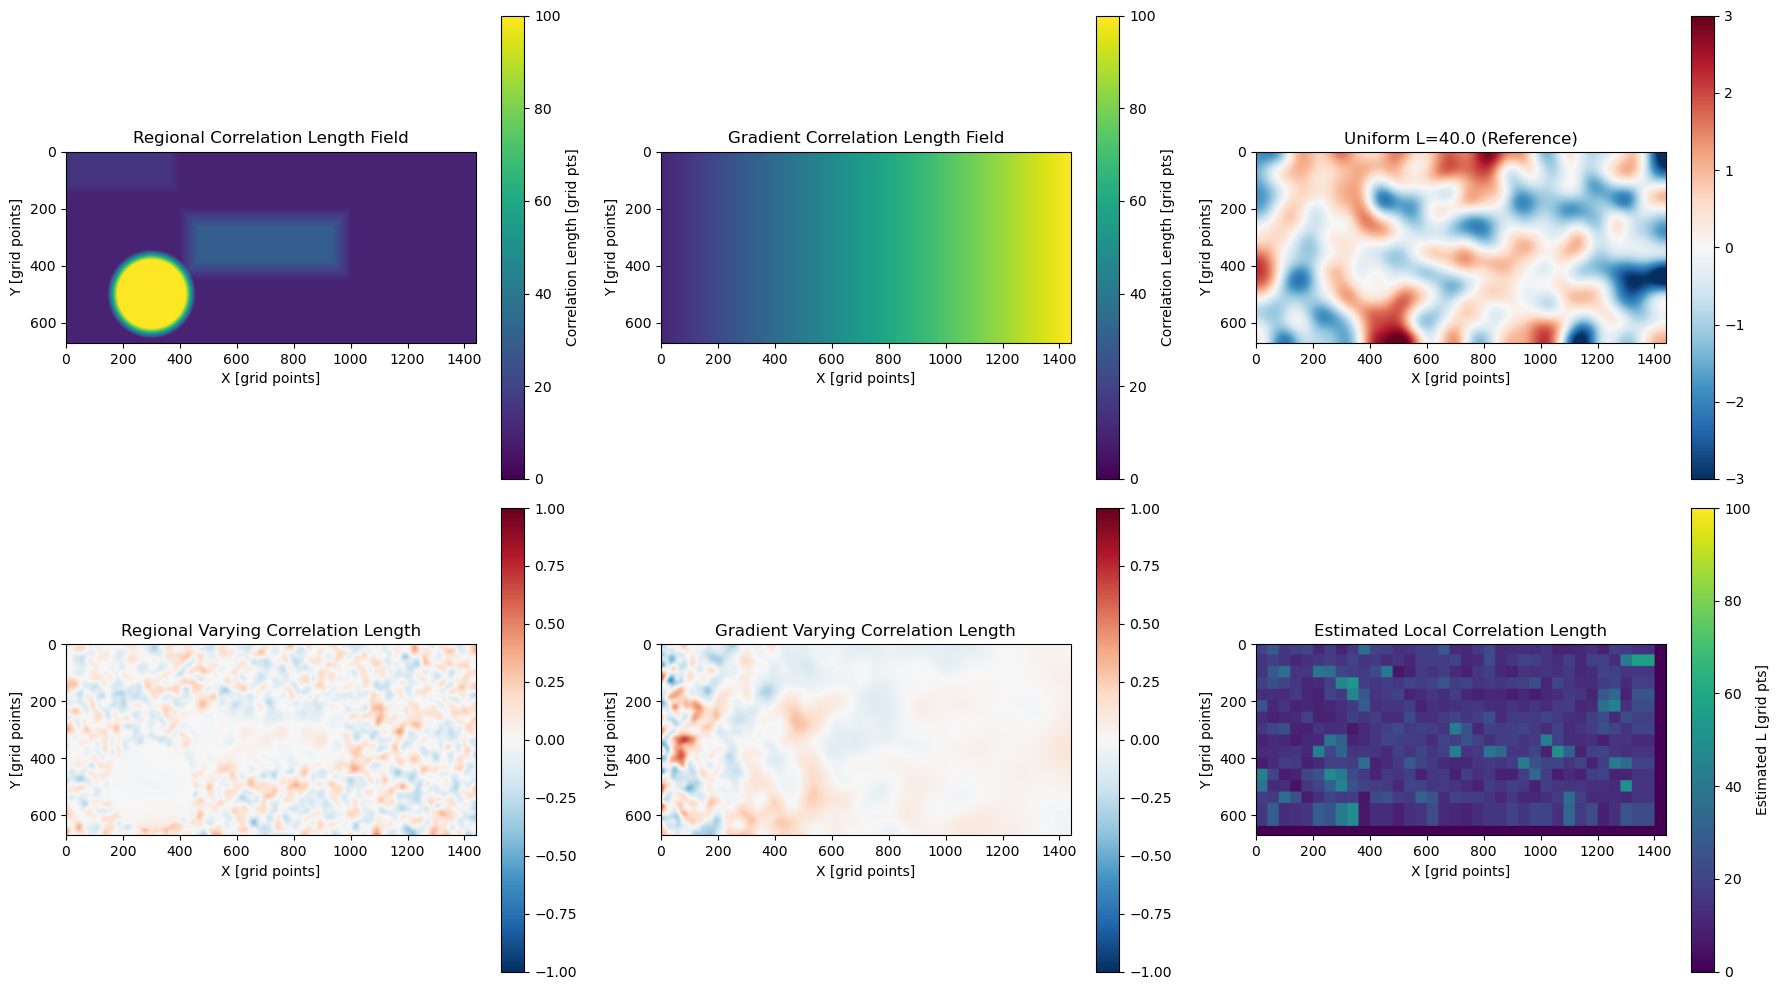

✓ Generated noise with spatially-varying correlation lengths
  Correlation length range: 10.0 - 100.0 grid points
  Small eddies (L~15) in coastal regions
  Large eddies (L~80) in open ocean


In [41]:
# Example: Different correlation lengths in different regions
ny, nx = 672, 1440

# Define regions with different correlation lengths
L_regions = [
    # Large eddies in central ocean
    {'type': 'box', 
     'correlation_length': 30,
     'coords': {'y_range': [200, 450], 
                'x_range': [400, 1000]},
     'blend': True, 
     'blend_width': 70},
    
    # Small eddies near coast
    {'type': 'box', 
     'correlation_length': 15.0,
     'coords': {'y_range': [0, 150], 
                'x_range': [0, 400]},
     'blend': True, 
     'blend_width': 35},
    
    # Medium eddies in circular region
    {'type': 'circle', 
     'correlation_length': 100,
     'coords': {'center': [500, 300], 
                'radius': 120},
     'blend': True, 
     'blend_width': 35},
]

# Create the correlation length field
L_field = create_correlation_length_field((ny, nx), L_regions, 10)

# Generate noise with spatially-varying correlation length
varying_L_noise = spatially_varying_gaussian_filter((ny, nx), L_field, amplitude=1.0, seed=22)


# Example 2: Gradient correlation length (e.g., increasing from coast to deep ocean)
L_gradient_regions = [
    {'type': 'gradient', 
     'coords': {'direction': 'x', 'L_start': 10.0, 'L_end': 100.0}}]

L_field_gradient = create_correlation_length_field((ny, nx), L_gradient_regions, 10)
gradient_L_noise = spatially_varying_gaussian_filter((ny, nx), L_field_gradient, amplitude=1.0, seed=23)


# Visualize
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot correlation length fields
im0 = axes[0, 0].imshow(L_field, cmap='viridis', vmin=0, vmax=100)
axes[0, 0].set_title('Regional Correlation Length Field')
axes[0, 0].set_xlabel('X [grid points]')
axes[0, 0].set_ylabel('Y [grid points]')
cbar0 = plt.colorbar(im0, ax=axes[0, 0])
cbar0.set_label('Correlation Length [grid pts]')

im1 = axes[0, 1].imshow(L_field_gradient, cmap='viridis', vmin=0, vmax=100)
axes[0, 1].set_title('Gradient Correlation Length Field')
axes[0, 1].set_xlabel('X [grid points]')
axes[0, 1].set_ylabel('Y [grid points]')
cbar1 = plt.colorbar(im1, ax=axes[0, 1])
cbar1.set_label('Correlation Length [grid pts]')

# Uniform correlation length for comparison
L_uniform = 40.0
uniform_L_noise = white_noise_to_correlated((ny, nx), L_uniform, amplitude=1.0, seed=13)
im2 = axes[0, 2].imshow(uniform_L_noise, cmap='RdBu_r', vmin=-3, vmax=3)
axes[0, 2].set_title(f'Uniform L={L_uniform} (Reference)')
axes[0, 2].set_xlabel('X [grid points]')
axes[0, 2].set_ylabel('Y [grid points]')
plt.colorbar(im2, ax=axes[0, 2])

# Plot noise fields with varying correlation lengths
im3 = axes[1, 0].imshow(varying_L_noise, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1, 0].set_title('Regional Varying Correlation Length')
axes[1, 0].set_xlabel('X [grid points]')
axes[1, 0].set_ylabel('Y [grid points]')
plt.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(gradient_L_noise, cmap='RdBu_r', vmin=-1, vmax=1)
axes[1, 1].set_title('Gradient Varying Correlation Length')
axes[1, 1].set_xlabel('X [grid points]')
axes[1, 1].set_ylabel('Y [grid points]')
plt.colorbar(im4, ax=axes[1, 1])

# Compute local correlation lengths by analyzing local spatial structure
def estimate_local_correlation_length(field, window_size=100, step=50):
    """Estimate correlation length from the field itself"""
    from scipy.signal import correlate
    
    ny, nx = field.shape
    L_estimated = np.zeros((ny, nx))
    
    for i in range(0, ny - window_size, step):
        for j in range(0, nx - window_size, step):
            # Extract local window
            window = field[i:i+window_size, j:j+window_size]
            window = (window - window.mean()) / (window.std() + 1e-10)
            
            # Compute 1D correlation along x
            corr = np.correlate(window[window_size//2, :], 
                               window[window_size//2, :], mode='full')
            corr = corr / corr.max()
            
            # Find e-folding scale (where correlation drops to 1/e)
            center = len(corr) // 2
            half_corr = corr[center:]
            try:
                L_local = np.where(half_corr < 1/np.e)[0][0]
            except:
                L_local = 10
            
            # Fill the region
            L_estimated[i:i+window_size, j:j+window_size] = L_local
    
    return L_estimated

# Estimate and plot
L_estimated = estimate_local_correlation_length(varying_L_noise, window_size=80, step=40)
im5 = axes[1, 2].imshow(L_estimated, cmap='viridis', vmin=0, vmax=100)
axes[1, 2].set_title('Estimated Local Correlation Length')
axes[1, 2].set_xlabel('X [grid points]')
axes[1, 2].set_ylabel('Y [grid points]')
cbar5 = plt.colorbar(im5, ax=axes[1, 2])
cbar5.set_label('Estimated L [grid pts]')

plt.tight_layout()
plt.show()

print("✓ Generated noise with spatially-varying correlation lengths")
print(f"  Correlation length range: {L_field.min():.1f} - {L_field.max():.1f} grid points")
print(f"  Small eddies (L~15) in coastal regions")
print(f"  Large eddies (L~80) in open ocean")


In [40]:
import xarray as xr


In [8]:
climato = xr.open_dataset("/Odyssey/public/glonet/1993-06-01_climatology/mean1.nc")
rand_ds = xr.open_dataset("/Odyssey/public/glonet/2022-06-01_init_states/input1.nc")

In [9]:
anomaly_ssh = climato.isel(time=0, ch=0)['data'] - rand_ds.isel(time=0, ch=0)['data']

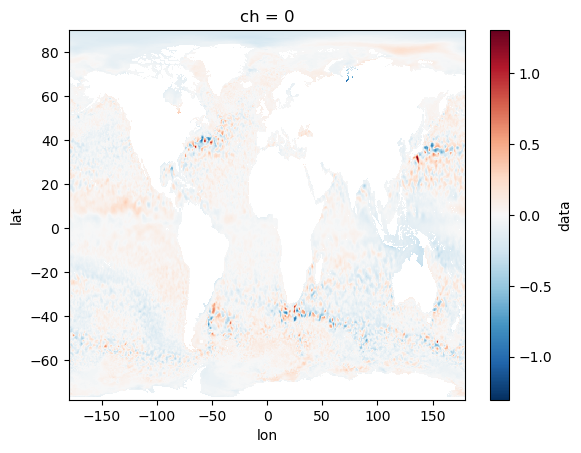

In [10]:
anomaly_ssh.plot()

In [11]:
# Create Gaussian filtered noise based on SSH anomaly with regional boxes
# Define 4 major dynamic ocean regions with CORRECTED correlation lengths

# Get dimensions from anomaly_ssh - note xarray dimensions are (lat, lon)
ny, nx = anomaly_ssh.shape
print(f"Data shape: {anomaly_ssh.shape}, dims: {anomaly_ssh.dims}")

# Define the 4 ocean boxes with CORRECTED geographic coordinates
ocean_regions = [
    # Gulf Stream (North Atlantic: 30-45°N, 80-50°W)
    {'name': 'Gulf Stream',
     'type': 'box', 
     'correlation_length': 5.0,  # Large mesoscale eddies
     'coords': {'y_range': [382, 542], 
                'x_range': [300, 620]},
     'blend': True, 
     'blend_width': 70},
    
    # Kuroshio (North Pacific: 30-45°N, 135-160°E)
    {'name': 'Kuroshio',
     'type': 'box', 
     'correlation_length': 5.0,  # Large western boundary current eddies
     'coords': {'y_range': [382, 542], 
                'x_range': [1160, 1460]},
     'blend': True, 
     'blend_width': 70},
    
    # Agulhas Current (South Indian Ocean: 45-30°S, 15-40°E)
    {'name': 'Agulhas',
     'type': 'box', 
     'correlation_length': 5.0,  # Strong retroflection eddies
     'coords': {'y_range': [82, 242], 
                'x_range': [680, 980]},
     'blend': True, 
     'blend_width': 70},
    
    # Antarctic Circumpolar Current (60-45°S, circumpolar)
    {'name': 'Antarctic ACC',
     'type': 'box', 
     'correlation_length': 10.0,  # Strong ACC dynamics
     'coords': {'y_range': [80, 162], 
                'x_range': [0, nx]},  # Circumpolar band
     'blend': True, 
     'blend_width': 30},
]

# Create the correlation length field with these regions
L_field_regions = create_correlation_length_field((ny, nx), ocean_regions, 50)

# Create amplitude field based on SSH anomaly magnitude
# Higher SSH variability = higher perturbation amplitude
ssh_std = float(np.nanstd(anomaly_ssh.values))
print(f"\nSSH anomaly std dev: {ssh_std:.3f} m")
amp_field_regions = (np.abs(anomaly_ssh.values)) / ssh_std   # Scale to reasonable amplitude

# Generate spatially-varying noise
regional_noise = spatially_varying_gaussian_filter((ny, nx), L_field_regions, amplitude=0.1)
print(f"\nMax regional noise (before scaling): {regional_noise.max():.4f}")
print(f"Min regional noise (before scaling): {regional_noise.min():.4f}")

# Scale by amplitude field (based on SSH anomaly)
regional_noise_scaled = regional_noise * amp_field_regions

# Apply land mask from the original data
# Create mask where ocean has valid data (not NaN)
land_mask = ~np.isnan(anomaly_ssh.values)
regional_noise_masked = np.where(land_mask, regional_noise_scaled, np.nan)

# Convert to xarray DataArray with proper coordinates for easier plotting
regional_noise_xr = xr.DataArray(
    regional_noise_masked,
    coords={'lat': anomaly_ssh.lat, 'lon': anomaly_ssh.lon},
    dims=['lat', 'lon'],
    name='noise_perturbation'
)

L_field_xr = xr.DataArray(
    L_field_regions,
    coords={'lat': anomaly_ssh.lat, 'lon': anomaly_ssh.lon},
    dims=['lat', 'lon'],
    name='correlation_length'
)

amp_field_xr = xr.DataArray(
    amp_field_regions,
    coords={'lat': anomaly_ssh.lat, 'lon': anomaly_ssh.lon},
    dims=['lat', 'lon'],
    name='amplitude'
)

print("✓ Created regional ocean perturbations with CORRECTED coordinates")
print(f"  - Gulf Stream (30-45°N, 80-50°W): L = {ocean_regions[0]['correlation_length']} grid pts")
print(f"  - Kuroshio (30-45°N, 135-160°E): L = {ocean_regions[1]['correlation_length']} grid pts")
print(f"  - Agulhas (45-30°S, 15-40°E): L = {ocean_regions[2]['correlation_length']} grid pts")
print(f"  - Antarctic ACC (60-45°S, circumpolar): L = {ocean_regions[3]['correlation_length']} grid pts")


Data shape: (672, 1440), dims: ('lat', 'lon')

SSH anomaly std dev: 0.094 m

Max regional noise (before scaling): 0.1270
Min regional noise (before scaling): -0.1267
✓ Created regional ocean perturbations with CORRECTED coordinates
  - Gulf Stream (30-45°N, 80-50°W): L = 5.0 grid pts
  - Kuroshio (30-45°N, 135-160°E): L = 5.0 grid pts
  - Agulhas (45-30°S, 15-40°E): L = 5.0 grid pts
  - Antarctic ACC (60-45°S, circumpolar): L = 10.0 grid pts

Max regional noise (before scaling): 0.1270
Min regional noise (before scaling): -0.1267
✓ Created regional ocean perturbations with CORRECTED coordinates
  - Gulf Stream (30-45°N, 80-50°W): L = 5.0 grid pts
  - Kuroshio (30-45°N, 135-160°E): L = 5.0 grid pts
  - Agulhas (45-30°S, 15-40°E): L = 5.0 grid pts
  - Antarctic ACC (60-45°S, circumpolar): L = 10.0 grid pts


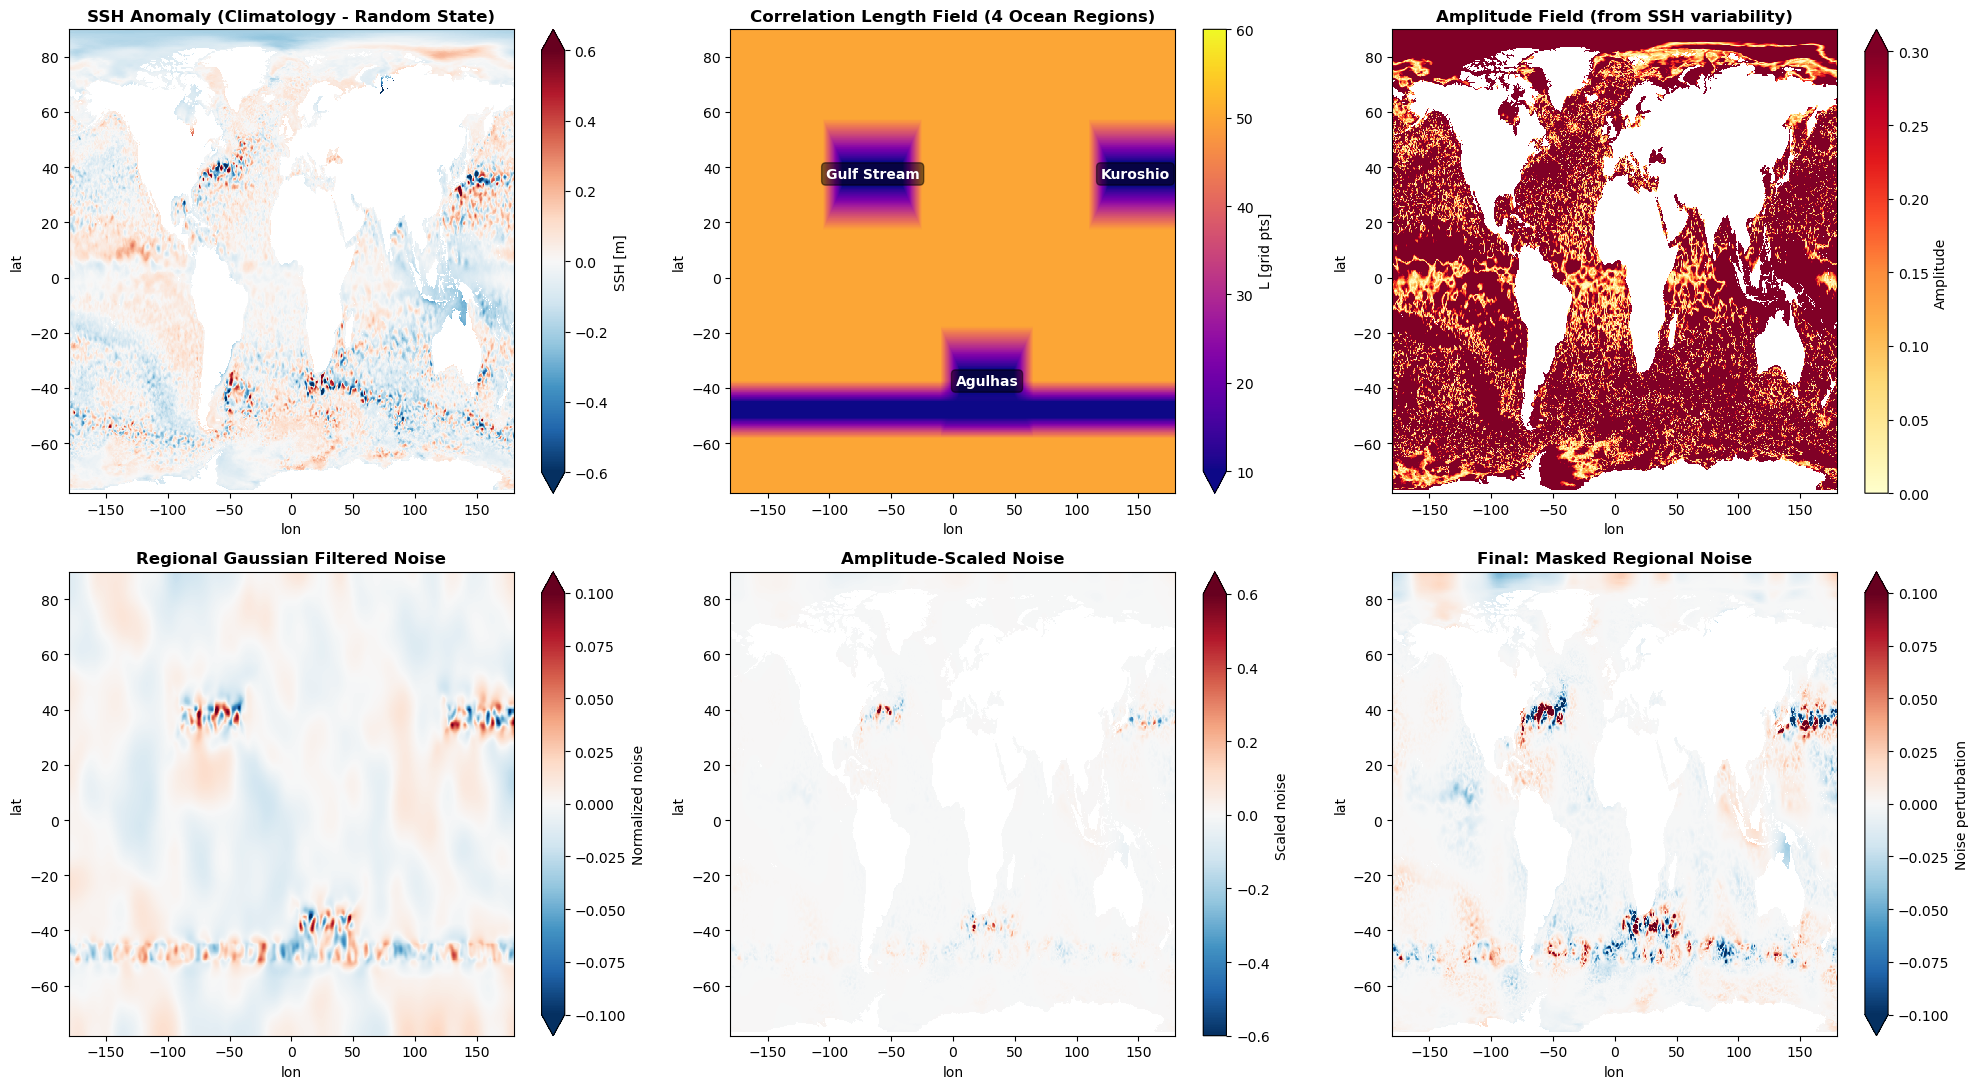


=== Global Sacled Noise Statistics ===
Valid ocean points: 675217 / 967680
Land points (NaN): 292463
Noise range: [-0.5374, 1.1345]
Noise std: 0.0210
SSH anomaly std: 0.0938
Relative noise amplitude: 22.4% of SSH variability


In [12]:
# Visualize the regional noise fields using xarray with proper coordinates
fig, axes = plt.subplots(2, 3, figsize=(20, 11))

# 1. Original SSH anomaly (using xarray for proper coordinates)
anomaly_ssh.plot(ax=axes[0, 0], cmap='RdBu_r', vmin=-0.6, vmax=0.6, add_colorbar=True, 
                 cbar_kwargs={'label': 'SSH [m]'})
axes[0, 0].set_title('SSH Anomaly (Climatology - Random State)', fontsize=12, fontweight='bold')
axes[0, 0].set_aspect('auto')

# 2. Correlation length field showing the 4 regions
L_field_xr.plot(ax=axes[0, 1], cmap='plasma', vmin=10, vmax=60, 
                cbar_kwargs={'label': 'L [grid pts]'})
axes[0, 1].set_title('Correlation Length Field (4 Ocean Regions)', fontsize=12, fontweight='bold')
axes[0, 1].set_aspect('auto')

# Add region labels
for region in ocean_regions:
    if region['type'] == 'box' and region['coords']['x_range'][1] - region['coords']['x_range'][0] < nx:
        y_range = region['coords']['y_range']
        x_range = region['coords']['x_range']
        y_center_idx = int((y_range[0] + y_range[1]) / 2)
        x_center_idx = int((x_range[0] + x_range[1]) / 2)
        lat_center = float(anomaly_ssh.lat.values[y_center_idx])
        lon_center = float(anomaly_ssh.lon.values[x_center_idx])
        axes[0, 1].text(lon_center, lat_center, region['name'], 
                       color='white', fontsize=10, fontweight='bold',
                       ha='center', va='center',
                       bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))

# 3. Amplitude field (based on SSH anomaly magnitude)
amp_field_xr.plot(ax=axes[0, 2], cmap='YlOrRd', vmin=0, vmax=0.3,
                  cbar_kwargs={'label': 'Amplitude'})
axes[0, 2].set_title('Amplitude Field (from SSH variability)', fontsize=12, fontweight='bold')
axes[0, 2].set_aspect('auto')

# 4. Generated noise (before scaling and masking)
regional_noise_unmasked_xr = xr.DataArray(
    regional_noise,
    coords={'lat': anomaly_ssh.lat, 'lon': anomaly_ssh.lon},
    dims=['lat', 'lon']
)
regional_noise_unmasked_xr.plot(ax=axes[1, 0], cmap='RdBu_r', vmin=-0.1, vmax=0.1,
                                 cbar_kwargs={'label': 'Normalized noise'})
axes[1, 0].set_title('Regional Gaussian Filtered Noise', fontsize=12, fontweight='bold')
axes[1, 0].set_aspect('auto')

# 5. Scaled noise (with amplitude but no mask)
regional_noise_scaled_xr = xr.DataArray(
    regional_noise_scaled,
    coords={'lat': anomaly_ssh.lat, 'lon': anomaly_ssh.lon},
    dims=['lat', 'lon']
)
regional_noise_scaled_xr.plot(ax=axes[1, 1], cmap='RdBu_r', vmin=-0.6, vmax=0.6,
                               cbar_kwargs={'label': 'Scaled noise'})
axes[1, 1].set_title('Amplitude-Scaled Noise', fontsize=12, fontweight='bold')
axes[1, 1].set_aspect('auto')

# 6. Final masked noise (with land mask applied)
regional_noise_xr.plot(ax=axes[1, 2], cmap='RdBu_r', vmin=-0.1, vmax=0.1,
                       cbar_kwargs={'label': 'Noise perturbation'})
axes[1, 2].set_title('Final: Masked Regional Noise', fontsize=12, fontweight='bold')
axes[1, 2].set_aspect('auto')

plt.tight_layout()
plt.show()

# Print statistics
print("\n=== Global Sacled Noise Statistics ===")
print(f"Valid ocean points: {np.sum(land_mask)} / {land_mask.size}")
print(f"Land points (NaN): {np.sum(~land_mask)}")
print(f"Noise range: [{np.nanmin(regional_noise_scaled):.4f}, {np.nanmax(regional_noise_scaled):.4f}]")
print(f"Noise std: {np.nanstd(regional_noise_scaled):.4f}")
print(f"SSH anomaly std: {ssh_std:.4f}")
print(f"Relative noise amplitude: {np.nanstd(regional_noise_scaled)/ssh_std*100:.1f}% of SSH variability")
